<a href="https://colab.research.google.com/github/marcelogarret/projeto_mestrado/blob/main/EBM_FIT_UNISIM_M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from sklearn.metrics import r2_score

df=pd.read_excel('unisim_hist-m.xlsx').iloc[1:,:]
# df=pd.read_excel('unisim_hist-m.xlsx').iloc[1:49,:]
df.head()

,Date,Press,Np,Gp,Wp,Winj
1,2013-06-30,332,0,0,0,0
2,2013-07-31,331,61938,6858068,0,0
3,2013-08-31,329,124403,13532213,0,0
4,2013-09-30,328,182423,20112443,0,0
5,2013-10-31,327,244857,26856741,0,0


In [1174]:
## Parametros escalares (MODSI)
# phi = 0.13
# k = 77
m = 0.0
Rsi = 113.06
Bw = 1.0210
uw = 0.3
cf = 5.3E-05
pb = 210.03
bob = 1.414
co = 1.62E-04
cw = 4.76E-05
Swi = 0.17
Sor = 0.18

In [1175]:
df["t"] = (df["Date"]-df["Date"].iloc[0]).astype("int64")/10**9/60/60/24
df["dt"]=df["t"].diff().fillna(0)
df["qo"]=(df["Np"].diff()/df["dt"]).fillna(0)
df["qg"]=(df["Gp"].diff()/df["dt"]).fillna(0)
df["qw"]=(df["Wp"].diff()/df["dt"]).fillna(0)
df["qwi"]=(df["Winj"].diff()/df["dt"]).fillna(0)
# df["p_med"]= (df["Press"]+(df["Press"]-df["Press"].diff()).fillna(df["Press"].iloc[0]))/2
# df["dp"]= df["Press"].iloc[0]-df["Press"]
# df["pmt"]=((df["Press"].iloc[0]-df["p_med"])*df["dt"]).cumsum()
df.tail()

,Date,Press,Np,Gp,Wp,Winj,t,dt,qo,qg,qw,qwi
128,2024-01-31,305,24757936,2793256452,4393983,36864922,3867.0,31.0,9053.0,986609.0,6446.0,19374.0
129,2024-02-29,306,25022300,2822363056,4583991,37475894,3896.0,29.0,9116.0,1003676.0,6552.0,21068.0
130,2024-03-31,307,25304090,2853787229,4789676,38123794,3927.0,31.0,9090.0,1013683.0,6635.0,20900.0
131,2024-04-30,308,25567400,2883725639,4991816,38702374,3957.0,30.0,8777.0,997947.0,6738.0,19286.0
132,2024-05-31,309,25832419,2913898931,5206739,39341191,3988.0,31.0,8549.0,973332.0,6933.0,20607.0


In [1176]:
## PVT functions

def func_bo(p, a, b):
    bo = np.zeros(len(p))
    for i in range(len(p)):
        if p[i] < pb:
          bo[i] = a * p[i] + b
        else:
          bo[i] = bob - co * (p[i] - pb)
    return bo

def func_bg(p, a, b):
    return a*p**(b)

def func_rs(p, a, b):
    rs = np.zeros(len(p))
    for i in range(len(p)):
      if p[i] < pb:
        rs[i] = a * p[i] + b
      else:
        rs[i] = Rsi
    return rs

def func_uo(p, a, b):
    return a*np.log(p)+b

def func_ug(p, a, b):
    return a*p+b

## Módulo de Ajuste de Histórico

In [1177]:
# EBM
# F/(Eo+mEg+(1+m)Efw)=N+We/(Eo+mEg+(1+m)Efw)
# We = F-N*(Eo+mEg+(1+m)Efw)

# Bt=Bo+(Rsi-Rs)*Bg
# F = Np*(Bt+(Rp-Rsi)*Bg)+(Wp-Winj)*Bw
# F = Np*(Bo+(Rsi-Rs)*Bg+(Rp-Rsi)*Bg)+(Wp-Winj)*Bw
# F = Np*(Bo+(Rp-Rs)*Bg)+(Wp-Winj)*Bw

# Eo= Bt-Bti

# Eg= Boi*(Bg/Bgi-1)

# Efw = Boi*((cf+cw.Swi)/(1-Swi))*∆p
# Efw = Boi*((cf+cw.Swi)/(1-Swi))*(pi-p)

p = df["Press"].values

bo = func_bo(p, 0.0012, 1.1538)
df["Bo"]=bo

bg = func_bg(p, 1.40676, -1.04229)
df["Bg"]=bg

rs = func_rs(p, 0.4655, 15.0114)
df["Rs"]=rs

uo = func_uo(p, -0.66947, 4.52463)
df["Viso"]=uo

ug = func_ug(p, 0.00005533, 0.00897493)
df["Visg"]=ug

df["Rp"] = (df["Gp"]/df["Np"]).fillna(0)

# df["Bt"]=df["Bo"]+(Rsi-df["Rs"])*df["Bg"]
# df["F"] = df["Np"]*(df["Bt"]+(df["Rp"]-Rsi)*df["Bg"])+(df["Wp"]-df["Winj"])*Bw
df["F"] = df["Np"]*(df["Bo"]+(df["Rp"]-df["Rs"])*df["Bg"])+(df["Wp"]-df["Winj"])*Bw
# df["Eo"] = df["Bt"]-df["Bt"].iloc[0]
df["Eo"] = df["Bo"]-df["Bo"].iloc[0]+(df["Rs"].iloc[0]-df["Rs"])*df["Bg"]
# df["Eg"] = df["Bt"].iloc[0]*(df["Bg"]/df["Bg"].iloc[0]-1)
df["Eg"] = df["Bo"].iloc[0]*((df["Bg"]/df["Bg"].iloc[0])-1)
# df["Efw"] = df["Bt"].iloc[0]*((cf+cw*Swi)/(1-Swi))*(df["Press"].iloc[0]-df["Press"])
df["Efw"] = (1+m)*df["Bo"].iloc[0]*((cf+cw*Swi)/(1-Swi))*(df["Press"].iloc[0]-df["Press"])

df.head()

,Date,Press,Np,Gp,Wp,Winj,t,dt,qo,qg,...,Bo,Bg,Rs,Viso,Visg,Rp,F,Eo,Eg,Efw
1,2013-06-30,332,0,0,0,0,0.0,0.0,0.0,0.0,...,1.394241,0.003315,113.06,0.638266,0.027344,0.000000,0.000000,0.000000,0.000000,0.000000
2,2013-07-31,331,61938,6858068,0,0,31.0,31.0,1998.0,221228.0,...,1.394403,0.003325,113.06,0.640286,0.027289,110.724725,85885.547962,0.000162,0.004391,0.000103
3,2013-08-31,329,124403,13532213,0,0,62.0,31.0,2015.0,215295.0,...,1.394727,0.003346,113.06,0.644343,0.027179,108.777224,171725.300945,0.000486,0.013254,0.000308
4,2013-09-30,328,182423,20112443,0,0,92.0,30.0,1934.0,219341.0,...,1.394889,0.003357,113.06,0.646381,0.027123,110.251684,252740.020631,0.000648,0.017727,0.000410
5,2013-10-31,327,244857,26856741,0,0,123.0,31.0,2014.0,217558.0,...,1.395051,0.003368,113.06,0.648425,0.027068,109.683370,338803.591700,0.000810,0.022227,0.000513


In [1178]:
train = df.copy()
# train = train.drop(["Gp", "Bt", "Bo", "Bg", "Rs", "F", "Eo", "Eg", "Efw", "p", "dt", "dp"], axis=1)

p=train["Press"].values
# p_med=train["p_med"].values
t=train["t"].values
dt=train["dt"].values
F=train["F"].values
Eo=train["Eo"].values
Eg=train["Eg"].values
Efw=train["Efw"].values
npp=train["Np"].values
gp=train["Gp"].values
rp=train["Rp"].values
wp=train["Wp"].values
winj=train["Winj"].values
qo=train["qo"].values
qg=train["qg"].values
qw=train["qw"].values
qwi=train["qwi"].values

Estimativa de N: 183.79
Estimativa de Wi: 100.00
Estimativas de J: 100.00
desvio (MMm³): 0.2056
r²: 0.75


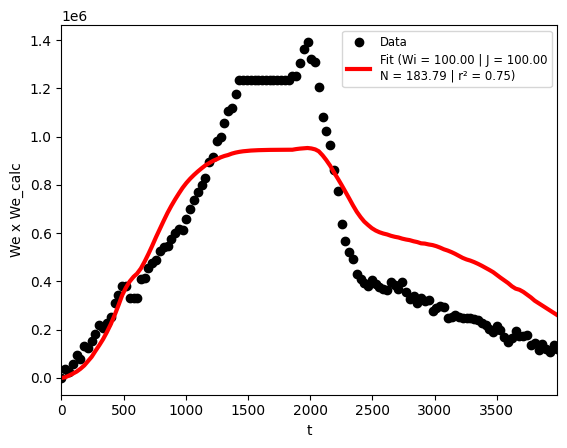

In [1179]:
## EBM generalizada
## We = F-N*(Eo+mEg+(1+m)Efw)
## F = N*(Eo+mEg+(1+m)Efw)+We

## Fetkovich
## ∆Wen = (Wei/pi).(pan-1-pn).[1-exp(-J.pi.∆t/Wei)]
## Wen = Wen-1+(Wei/pi).(pan-1-pn).[1-exp(-J.pi.∆t/Wei)]
## pan-1 = pi.[1-Wen-1/Wei]
## pn = [pn-1+pn]/2
## ∆t = t_j+1-t_j
## n = 1....n

##Aquífero Fetkovich

# Função objetivo
def objective(x, Eo, Eg, Efw, F, m):
    N = x[0]  # N é constante
    Wi = x[1]  # Wei é constante
    J = x[2]  # J é constante
    Wei = (cf+cw)*Wi*p[0]*10**6
    Wen = np.zeros(len(t))
    pa_med = np.zeros(len(t))
    pa_med[0] = p[0]
    for i in range(1,len(t)):
      pa_med[i-1]=p[0]*(1-(Wen[i-1]/Wei))
      Wen[i]=Wen[i-1]+(Wei/p[0])*(pa_med[i-1]-p[i])*(1-np.exp(-J*p[0]*dt[i]/Wei))
    We_EBM = F - (N*10**6) * (Eo + m * Eg + Efw)
    return np.mean(((We_EBM - Wen)/10**6) ** 2)**0.5
    # return np.sum((We_EBM - Wen) ** 2)

# Chute inicial para N, Wi e J
x0 = np.array([130] + [100] + [10])

# Limites para N, Wi e J
bounds = [(10, 300)] + [(100, 1000)] + [(1, 100)]

# Otimização com restrições
result = minimize(objective, x0, args=(Eo, Eg, Efw, F, m), bounds=bounds)

N_est = result.x[0]
Wi_est = result.x[1]
J_est = result.x[2]

print(f"Estimativa de N: {N_est:0.2f}")
print(f"Estimativa de Wi: {Wi_est:0.2f}")
print(f"Estimativas de J: {J_est:0.2f}")

Wei_est = (cf+cw)*Wi_est*p[0]*10**6
# print(Wei_est)
Wen = np.zeros(len(t))
pa_med = np.zeros(len(t))
pa_med[0] = p[0]
for i in range(1,len(t)):
  pa_med[i-1] = p[0]*(1-(Wen[i-1]/Wei_est))
  Wen[i] = Wen[i-1]+(Wei_est/p[0])*(pa_med[i-1]-p[i])*(1-np.exp(-J_est*p[0]*dt[i]/Wei_est))
pa_med[len(t)-1] = p[0]*(1-(Wen[len(t)-1]/Wei_est))
We_EBM = F - (N_est*10**6) * (Eo + m * Eg + Efw)
print(f"desvio (MMm³): {np.mean(((We_EBM - Wen)/10**6) ** 2)**0.5:0.4f}")

r2_2 = r2_score(We_EBM, Wen)
print(f"r²: {r2_2:0.2f}")

plt.scatter(t, We_EBM, label="Data", color="black")
plt.plot(t, Wen, label=f"Fit (Wi = {Wi_est:0.2f} | J = {J_est:0.2f}" + "\n" + f"N = {N_est:0.2f} | r\N{SUPERSCRIPT TWO} = {r2_2:.2f})", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("We x We_calc")
plt.xlim(0, df.iloc[-1, 6])
plt.show()

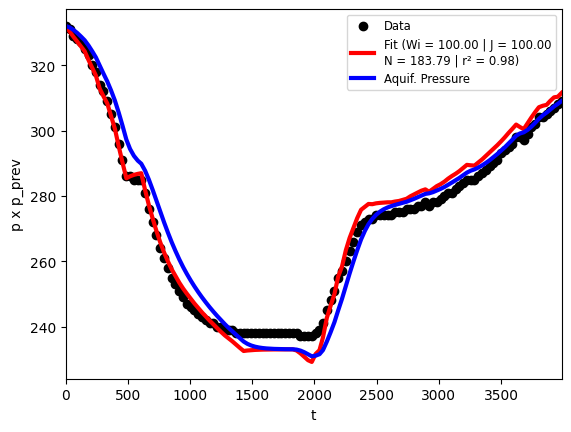

In [1180]:
## Previsao de pressao

p_prev=np.zeros(len(t))
we_aquif=np.zeros(len(t))
ppa_med=np.zeros(len(t))
we_ebm=np.zeros(len(t))

for i in range(len(t)):
  if i == 0:
    p_prev[i]=p[0]
    we_aquif[i]=0
    ppa_med[i]=p[0]
    we_ebm[i]=0
  else:
    # Função objetivo
    def obj_f(x, m, N, Wei, J):
      pn = x[0]  # pressao prevista

      ## Aquifero
      ppa_med[i-1]=p[0]*(1-(we_aquif[i-1]/Wei))
      we_aquif[i]=we_aquif[i-1]+(Wei/p[0])*(ppa_med[i-1]-pn)*(1-np.exp(-J*p[0]*dt[i]/Wei))

      ## EBM
      if pn < pb:
        bop = 0.0012 * pn + 1.1538
        rsp = 0.4655 * pn + 15.0114
      else:
        bop = bob - co * (pn - pb)
        rsp = Rsi
      bgp = 1.40676*pn**(-1.04229)
      fp=npp[i]*(bop+(rp[i]-rsp)*bgp)+(wp[i]-winj[i])*Bw
      eop=bop-bo[0]+(Rsi-rsp)*bgp
      egp=bo[0]*((bgp/bg[0])-1)
      efwp=(1+m)*bo[0]*((cf+cw*Swi)/(1-Swi))*(p[0]-pn)
      we_ebm[i]=fp-N*(eop+m*egp+efwp)*10**6

      return (we_ebm[i] - we_aquif[i]) ** 2

    x0 = [p_prev[i-1]]
    result = minimize(obj_f, x0, args=(m, N_est, Wei_est, J_est))
    p_prev[i]=result.x[0]

  ppa_med[i]=p[0]*(1-(we_aquif[i]/Wei_est))

r2_2 = r2_score(p, p_prev)
# print(p_prev)

plt.scatter(t, p, label="Data", color="black")
plt.plot(t, p_prev, label=f"Fit (Wi = {Wi_est:0.2f} | J = {J_est:0.2f}" + "\n" + f"N = {N_est:0.2f} | r\N{SUPERSCRIPT TWO} = {r2_2:.2f})", color="red", linewidth=3)
plt.plot(t, ppa_med, label="Aquif. Pressure", color="blue", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("p x p_prev")
plt.xlim(0, df.iloc[-1, 6])
plt.show()

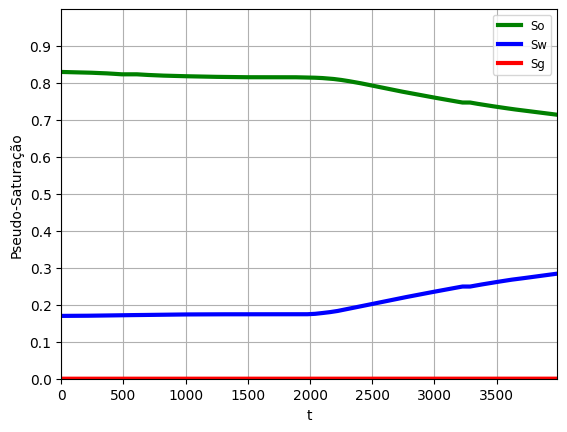

In [1181]:
## Saturacoes de fluidos

So = np.zeros(len(t))
Sw = np.zeros(len(t))
Sg = np.zeros(len(t))
cct = np.zeros(len(t))
Vpp = np.zeros(len(t))
Vp = (N_est*10**6) * bo[0] / (1 - Swi)
G = ((N_est*10**6) * Rsi + m * (N_est*10**6) * bo[0] / bg[0])
# print(G)

for i in range(len(t)):
  cct[i] = (1 + (Swi * cw / (1 - Swi) + cf) * (p[i] - p[0]))
  Vpp[i] = Vp * (1 + cf * (p[i] - p[0]))
  So[i] = ((N_est*10**6) - npp[i]) *bo[0] / Vpp[i]
  Sw[i] = (Swi * Vp * (1 - cw * (p[i] - p[0])) + ((winj[i] - wp[i] + Wen[i]) * Bw)) / Vpp[i]
  Sg[i] = bg[i] * (G - gp[i] - ((N_est*10**6) - npp[i]) * rs[i] - cct[i] * m * (N_est*10**6) * bo[0] / bg[0]) / Vpp[i]

# print(Sg)
fig = plt.figure()
ax = fig.gca()
ax.set_yticks(np.arange(0, 1., 0.1))
plt.grid()
plt.plot(t, So, label="So", color="green", linewidth=3)
plt.plot(t, Sw, label="Sw", color="blue", linewidth=3)
plt.plot(t, Sg, label="Sg", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("Pseudo-Saturação")
plt.ylim(0.0, 1.0)
plt.xlim(0, df.iloc[-1, 6])
plt.show()

In [1182]:
df["P_prev"]=p_prev
df["So"]=So
df["Sw"]=Sw
df["Sg" ]=Sg
df["We_ebm"]=We_EBM
df["We_aqui"]=Wen
df["Pa_med"]=ppa_med
df["cct"]=cct
df["Vpp"]=Vpp

df

,Date,Press,Np,Gp,Wp,Winj,t,dt,qo,qg,...,Efw,P_prev,So,Sw,Sg,We_ebm,We_aqui,Pa_med,cct,Vpp
1,2013-06-30,332,0,0,0,0,0.0,0.0,0.0,0.0,...,0.000000,332.000000,0.830000,0.170000,0.000000,0.000000,0.000000,332.000000,1.000000,3.087348e+08
2,2013-07-31,331,61938,6858068,0,0,31.0,31.0,1998.0,221228.0,...,0.000103,330.325815,0.829764,0.170026,0.000002,37250.066132,2667.868888,331.556013,0.999937,3.087184e+08
3,2013-08-31,329,124403,13532213,0,0,62.0,31.0,2015.0,215295.0,...,0.000308,328.716639,0.829570,0.170084,0.000006,25818.855457,9963.968155,330.803024,0.999812,3.086857e+08
4,2013-09-30,328,182423,20112443,0,0,92.0,30.0,1934.0,219341.0,...,0.000410,327.240600,0.829352,0.170127,0.000006,58198.093313,17770.796559,329.884435,0.999749,3.086694e+08
5,2013-10-31,327,244857,26856741,0,0,123.0,31.0,2014.0,217558.0,...,0.000513,325.700118,0.829114,0.170173,0.000009,95626.182553,26397.401907,328.774772,0.999686,3.086530e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,2024-01-31,305,24757936,2793256452,4393983,36864922,3867.0,31.0,9053.0,986609.0,...,0.002771,307.845576,0.719223,0.278992,0.000069,139552.721240,299769.709011,305.485027,0.998306,3.082930e+08
129,2024-02-29,306,25022300,2822363056,4583991,37475894,3896.0,29.0,9116.0,1003676.0,...,0.002668,309.054545,0.717989,0.280331,0.000078,121322.652603,290200.427486,306.378981,0.998369,3.083094e+08
130,2024-03-31,307,25304090,2853787229,4789676,38123794,3927.0,31.0,9090.0,1013683.0,...,0.002566,310.153878,0.716677,0.281739,0.000083,106944.395433,279937.239968,307.380067,0.998431,3.083257e+08
131,2024-04-30,308,25567400,2883725639,4991816,38702374,3957.0,30.0,8777.0,997947.0,...,0.002463,310.334088,0.715448,0.282929,0.000080,135967.292351,270010.531343,308.141777,0.998494,3.083421e+08


## Módulo de Previsão

In [1183]:
date=df["Date"].values
date_time=pd.to_datetime(date)
date_time

DatetimeIndex(['2013-06-30', '2013-07-31', '2013-08-31', '2013-09-30',
               '2013-10-31', '2013-11-30', '2013-12-31', '2014-01-31',
               '2014-02-28', '2014-03-31',
               ...
               '2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30',
               '2023-12-31', '2024-01-31', '2024-02-29', '2024-03-31',
               '2024-04-30', '2024-05-31'],
              dtype='datetime64[ns]', length=132, freq=None)

In [1184]:
from pandas.tseries.offsets import MonthEnd

# Última data fornecida
last_date = date_time[-1]

# Quantidade de meses na previsão
n_months = 24

# Gerar novas datas, no último dia de cada mês seguinte
new_dates = pd.to_datetime([last_date + MonthEnd(n) for n in range(1, n_months+1)])
new_dates

# (new_dates[0]-date_time[-1]).days

DatetimeIndex(['2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
               '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31', '2025-04-30', '2025-05-31',
               '2025-06-30', '2025-07-31', '2025-08-31', '2025-09-30',
               '2025-10-31', '2025-11-30', '2025-12-31', '2026-01-31',
               '2026-02-28', '2026-03-31', '2026-04-30', '2026-05-31'],
              dtype='datetime64[ns]', freq=None)

In [1185]:
## Forecast Dataframe

fc = pd.DataFrame(new_dates, columns=['Date'])
fc = pd.concat([df, fc], ignore_index=True).fillna(0)
fc["t"] = (fc["Date"]-fc["Date"].iloc[0]).astype("int64")/10**9/60/60/24
fc["dt"]=fc["t"].diff().fillna(0)
fc

,Date,Press,Np,Gp,Wp,Winj,t,dt,qo,qg,...,Efw,P_prev,So,Sw,Sg,We_ebm,We_aqui,Pa_med,cct,Vpp
0,2013-06-30,332.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,332.000000,0.830000,0.170000,0.000000,0.000000,0.000000,332.000000,1.000000,3.087348e+08
1,2013-07-31,331.0,61938.0,6858068.0,0.0,0.0,31.0,31.0,1998.0,221228.0,...,0.000103,330.325815,0.829764,0.170026,0.000002,37250.066132,2667.868888,331.556013,0.999937,3.087184e+08
2,2013-08-31,329.0,124403.0,13532213.0,0.0,0.0,62.0,31.0,2015.0,215295.0,...,0.000308,328.716639,0.829570,0.170084,0.000006,25818.855457,9963.968155,330.803024,0.999812,3.086857e+08
3,2013-09-30,328.0,182423.0,20112443.0,0.0,0.0,92.0,30.0,1934.0,219341.0,...,0.000410,327.240600,0.829352,0.170127,0.000006,58198.093313,17770.796559,329.884435,0.999749,3.086694e+08
4,2013-10-31,327.0,244857.0,26856741.0,0.0,0.0,123.0,31.0,2014.0,217558.0,...,0.000513,325.700118,0.829114,0.170173,0.000009,95626.182553,26397.401907,328.774772,0.999686,3.086530e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,2026-01-31,0.0,0.0,0.0,0.0,0.0,4598.0,31.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
152,2026-02-28,0.0,0.0,0.0,0.0,0.0,4626.0,28.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
153,2026-03-31,0.0,0.0,0.0,0.0,0.0,4657.0,31.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
154,2026-04-30,0.0,0.0,0.0,0.0,0.0,4687.0,30.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00


In [1186]:
fc_train = fc.copy()

p_fc=fc_train["Press"].values
npp_fc=fc_train["Np"].values
gp_fc=fc_train["Gp"].values
wp_fc=fc_train["Wp"].values
winj_fc=fc_train["Winj"].values
t_fc=fc_train["t"].values
dt_fc=fc_train["dt"].values
qo_fc=fc_train["qo"].values
qg_fc=fc_train["qg"].values
qw_fc=fc_train["qw"].values
qwi_fc=fc_train["qwi"].values
bo_fc=fc_train["Bo"].values
bg_fc=fc_train["Bg"].values
rs_fc=fc_train["Rs"].values
rp_fc=fc_train["Rp"].values
f_fc=fc_train["F"].values
eo_fc=fc_train["Eo"].values
eg_fc=fc_train["Eg"].values
efw_fc=fc_train["Efw"].values
p_prev_fc=fc_train["P_prev"].values
so_fc=fc_train["So"].values
sw_fc=fc_train["Sw"].values
sg_fc=fc_train["Sg"].values
we_ebm_fc=fc_train["We_ebm"].values
wen_fc=fc_train["We_aqui"].values
pa_med_fc=fc_train["Pa_med"].values
cct_fc=fc_train["cct"].values
Vpp_fc=fc_train["Vpp"].values
uo_fc=fc_train["Viso"].values
ug_fc=fc_train["Visg"].values

# fc_train.iloc[df.shape[0]-2:df.shape[0]+1,5:25]

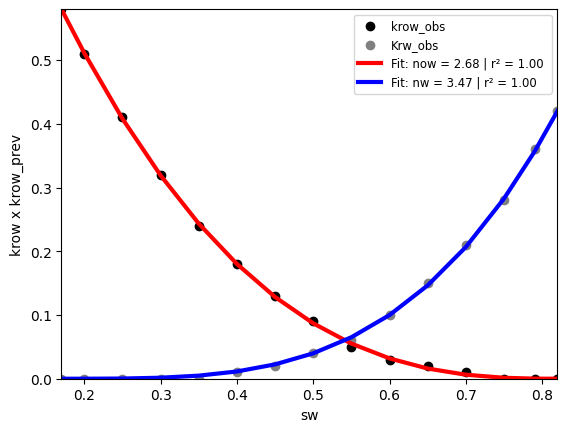

In [1187]:
## Permeabilidade Relativa Óleo-Água

sw = np.array([0.17, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.79, 0.82])
krow_obs = np.array([0.58, 0.51, 0.41, 0.32, 0.24, 0.18, 0.13, 0.09, 0.05, 0.03, 0.02, 0.01, 0, 0, 0])
krw_obs = np.array([0, 0, 0, 0, 0, 0.01, 0.02, 0.04, 0.06, 0.1, 0.15, 0.21, 0.28, 0.36, 0.42])

krow_max = krow_obs[0]
krw_max = krw_obs[-1]

def f_krow(sw, now):
  return krow_max*((1-Sor-sw)/(1-Sor-Swi))**now

def f_krw(sw, nw):
  return krw_max*((sw-Swi)/(1-Sor-Swi))**nw

## Ajuste krow
initialGuess1=[2]
popt1,pcov1 = curve_fit(f_krow, sw, krow_obs, initialGuess1)
krow_pred = f_krow(sw, *popt1)
r2_1 = r2_score(krow_obs, krow_pred)
now = popt1[0]

## Ajuste krw
initialGuess2=[2]
popt2,pcov2 = curve_fit(f_krw, sw, krw_obs, initialGuess2)
krw_pred = f_krw(sw, *popt2)
r2_2 = r2_score(krw_obs, krw_pred)
nw = popt2[0]

plt.scatter(sw, krow_obs, label="krow_obs", color="black")
plt.scatter(sw, krw_obs, label="Krw_obs", color="grey")
plt.plot(sw, krow_pred, label=f"Fit: now = {now:0.2f} | r\N{SUPERSCRIPT TWO} = {r2_1:0.2f} ", color="red", linewidth=3)
plt.plot(sw, krw_pred, label=f"Fit: nw = {nw:0.2f} | r\N{SUPERSCRIPT TWO} = {r2_2:0.2f}", color="blue", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("sw")
plt.ylabel("krow x krow_prev")
plt.xlim(sw[0], sw[-1])
plt.ylim(0, krow_max)
plt.show()

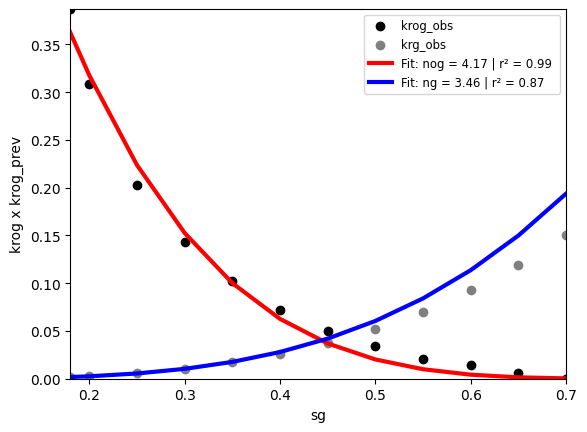

In [1188]:
## Permeabilidade Relativa Gás-Óleo

sg = np.array([0.18, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7])
krog_obs = np.array([0.387, 0.309, 0.203, 0.143, 0.102, 0.072, 0.05, 0.034, 0.021, 0.014, 0.006, 0])
krg_obs = np.array([0.002, 0.003, 0.006, 0.01, 0.017, 0.026, 0.037, 0.052, 0.07, 0.093, 0.119, 0.15])

krog_max = krog_obs[0]
krg_max = krg_obs[-1]

def f_krog(sg, nog):
  return krog_max*((1-Sor-sg)/(1-Sor-Swi))**nog ## verificar fórmula

def f_krg(sg, ng):
  return krg_max*(sg/(1-Sor-Swi))**ng

## Ajuste krog
initialGuess1=[3]
popt1,pcov1 = curve_fit(f_krog, sg, krog_obs, initialGuess1)
krog_pred = f_krog(sg, *popt1)
r2_1 = r2_score(krog_obs, krog_pred)
nog = popt1[0]

## Ajuste krg
initialGuess2=[3]
popt2,pcov2 = curve_fit(f_krg, sg, krg_obs, initialGuess2)
krg_pred = f_krg(sg, *popt2)
r2_2 = r2_score(krg_obs, krg_pred)
ng = popt2[0]

plt.scatter(sg, krog_obs, label="krog_obs", color="black")
plt.scatter(sg, krg_obs, label="krg_obs", color="grey")
plt.plot(sg, krog_pred, label=f"Fit: nog = {nog:0.2f} | r\N{SUPERSCRIPT TWO} = {r2_1:0.2f} ", color="red", linewidth=3)
plt.plot(sg, krg_pred, label=f"Fit: ng = {ng:0.2f} | r\N{SUPERSCRIPT TWO} = {r2_2:0.2f}", color="blue", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("sg")
plt.ylabel("krog x krog_prev")
plt.xlim(sg[0], sg[-1])
plt.ylim(0, krog_max)
plt.show()

In [1189]:
## Forecast

for n in range(n_months):
  ## Previsão de vazões
  RAO = uo_fc[df.shape[0]+n-1]*f_krw(sw_fc[df.shape[0]+n-1], nw)*bo_fc[df.shape[0]+n-1]/(uw*f_krow(sw_fc[df.shape[0]+n-1], now)*Bw)
  RGO = uo_fc[df.shape[0]+n-1]*f_krg(sg_fc[df.shape[0]+n-1], ng)*bo_fc[df.shape[0]+n-1]/(ug_fc[df.shape[0]+n-1]*f_krog(sg_fc[df.shape[0]+n-1], nog)*bg_fc[df.shape[0]+n-1])+rs_fc[df.shape[0]+n-1]

  qo_fc[df.shape[0]+n]=qo_fc[df.shape[0]+n-1]**2/qo_fc[df.shape[0]+n-2]
  qg_fc[df.shape[0]+n]=qg_fc[df.shape[0]+n-1]/qo_fc[df.shape[0]+n-1]*qo_fc[df.shape[0]+n]
  qw_fc[df.shape[0]+n]=qw_fc[df.shape[0]+n-1]**2/qw_fc[df.shape[0]+n-2]
  qwi_fc[df.shape[0]+n]=np.mean(qwi_fc[df.shape[0]+n-12:df.shape[0]+n]) #*0.75

  ## Previsão de acumuladas
  npp_fc[df.shape[0]+n]=npp_fc[df.shape[0]+n-1]+qo_fc[df.shape[0]+n]*dt_fc[df.shape[0]+n]
  gp_fc[df.shape[0]+n]=gp_fc[df.shape[0]+n-1]+qg_fc[df.shape[0]+n]*dt_fc[df.shape[0]+n]
  wp_fc[df.shape[0]+n]=wp_fc[df.shape[0]+n-1]+qw_fc[df.shape[0]+n]*dt_fc[df.shape[0]+n]
  winj_fc[df.shape[0]+n]=winj_fc[df.shape[0]+n-1]+qwi_fc[df.shape[0]+n]*dt_fc[df.shape[0]+n]
  rp_fc[df.shape[0]+n]=gp_fc[df.shape[0]+n]/npp_fc[df.shape[0]+n]

  # Previsão de pressão
  def obj_f(x, m, N, Wei, J):
    pn = x[0]  # pressao prevista

    ## Aquifero
    pa_med_fc[df.shape[0]+n-1]=p_fc[0]*(1-(wen_fc[df.shape[0]+n-1]/Wei))
    wen_fc[df.shape[0]+n]=wen_fc[df.shape[0]+n-1]+(Wei/p_fc[0])*(pa_med_fc[df.shape[0]+n-1]-pn)*(1-np.exp(-J*p_fc[0]*dt_fc[df.shape[0]+n]/Wei))

    ## EBM
    if pn < pb:
      bo_fc[df.shape[0]+n] = 0.0012 * pn + 1.1538
      rs_fc[df.shape[0]+n] = 0.4655 * pn + 15.0114
    else:
      bo_fc[df.shape[0]+n] = bob - co * (pn - pb)
      rs_fc[df.shape[0]+n] = Rsi
    bg_fc[df.shape[0]+n] = 1.40676*pn**(-1.04229)
    f_fc[df.shape[0]+n]=npp_fc[df.shape[0]+n]*(bo_fc[df.shape[0]+n]+(rp_fc[df.shape[0]+n]-rs_fc[df.shape[0]+n])*bg_fc[df.shape[0]+n])+(wp_fc[df.shape[0]+n]-winj_fc[df.shape[0]+n])*Bw

    eo_fc[df.shape[0]+n]=bo_fc[df.shape[0]+n]-bo_fc[0]+(Rsi-rs_fc[df.shape[0]+n])*bg_fc[df.shape[0]+n]
    eg_fc[df.shape[0]+n]=bo_fc[0]*((bg_fc[df.shape[0]+n]/bg_fc[0])-1)
    efw_fc[df.shape[0]+n]=(1+m)*bo_fc[0]*((cf+cw*Swi)/(1-Swi))*(p_fc[0]-pn)
    we_ebm_fc[df.shape[0]+n]=f_fc[df.shape[0]+n]-N*(eo_fc[df.shape[0]+n]+m*eg_fc[df.shape[0]+n]+efw_fc[df.shape[0]+n])*10**6
    return (we_ebm_fc[df.shape[0]+n] - wen_fc[df.shape[0]+n]) ** 2
  x0 = [p_prev_fc[df.shape[0]+n-1]]
  result = minimize(obj_f, x0, args=(m, N_est, Wei_est, J_est))

  p_prev_fc[df.shape[0]+n]=result.x[0]
  pa_med_fc[df.shape[0]+n]=p_fc[0]*(1-(wen_fc[df.shape[0]+n]/Wei_est))

  ## Previsão de saturações
  cct_fc[df.shape[0]+n] = (1 + (Swi * cw / (1 - Swi) + cf) * (p_prev_fc[df.shape[0]+n] - p_fc[0]))
  Vpp_fc[df.shape[0]+n] = Vp * (1 + cf * (p_prev_fc[df.shape[0]+n] - p_fc[0]))
  so_fc[df.shape[0]+n] = ((N_est*10**6) - npp_fc[df.shape[0]+n]) *bo_fc[0] / Vpp_fc[df.shape[0]+n]
  sw_fc[df.shape[0]+n] = (Swi * Vp * (1 - cw * (p_prev_fc[df.shape[0]+n] - p_fc[0])) + ((winj_fc[df.shape[0]+n] - wp_fc[df.shape[0]+n] + wen_fc[df.shape[0]+n]) * Bw)) / Vpp_fc[df.shape[0]+n]
  sg_fc[df.shape[0]+n] = bg_fc[df.shape[0]+n] * (G - gp_fc[df.shape[0]+n] - ((N_est*10**6) - npp_fc[df.shape[0]+n]) * rs_fc[df.shape[0]+n] - cct_fc[df.shape[0]+n] * m * (N_est*10**6) * bo_fc[0] / bg_fc[0]) / Vpp_fc[df.shape[0]+n]

  ## Previsão de viscosidades
  uo_fc[df.shape[0]+n]=-0.66947*np.log(p_prev_fc[df.shape[0]+n])+4.52463
  ug_fc[df.shape[0]+n]=0.00005533*p_prev_fc[df.shape[0]+n]+0.00897493

fc_train.iloc[df.shape[0]-1:fc.shape[0],:]

,Date,Press,Np,Gp,Wp,Winj,t,dt,qo,qg,...,Efw,P_prev,So,Sw,Sg,We_ebm,We_aqui,Pa_med,cct,Vpp
131,2024-05-31,309.0,2.583242e+07,2.913899e+09,5.206739e+06,3.934119e+07,3988.0,31.0,8549.000000,973332.000000,...,0.002360,311.515670,0.714212,0.284276,0.000078,118987.656691,259765.879982,306.178342,0.998557,3.083585e+08
132,2024-06-30,0.0,2.608223e+07,2.942340e+09,5.420748e+06,3.995164e+07,4018.0,30.0,8326.922753,948047.768942,...,0.001950,312.999303,0.712931,0.285437,0.000074,242072.156263,242072.156614,307.937161,0.998808,3.084239e+08
133,2024-07-31,0.0,2.633366e+07,2.970966e+09,5.648291e+06,4.058805e+07,4049.0,31.0,8110.614403,923420.345982,...,0.001837,314.101238,0.711753,0.286710,0.000072,225627.207952,225627.208299,309.571848,0.998877,3.084419e+08
134,2024-08-31,0.0,2.657855e+07,2.998849e+09,5.882419e+06,4.123043e+07,4080.0,31.0,7899.925092,899432.669226,...,0.001702,315.416523,0.710596,0.287979,0.000069,210034.382151,210034.381801,311.121831,0.998959,3.084635e+08
135,2024-09-30,0.0,2.680939e+07,3.025131e+09,6.115552e+06,4.184957e+07,4110.0,30.0,7694.708854,876068.119997,...,0.001571,316.691436,0.709505,0.289179,0.000067,195586.702862,195586.703212,312.557982,0.999039,3.084843e+08
136,2024-10-31,0.0,2.704173e+07,3.051583e+09,6.363428e+06,4.248704e+07,4141.0,31.0,7494.823515,853310.511320,...,0.001436,318.002200,0.708406,0.290390,0.000065,181062.241786,181062.242101,314.001765,0.999122,3.085058e+08
137,2024-11-30,0.0,2.726074e+07,3.076518e+09,6.610249e+06,4.310093e+07,4171.0,30.0,7300.130594,831144.076709,...,0.001310,319.238674,0.707369,0.291531,0.000062,167477.584349,167477.584000,315.352129,0.999199,3.085260e+08
138,2024-12-31,0.0,2.748116e+07,3.101614e+09,6.872680e+06,4.373227e+07,4202.0,31.0,7110.495209,809553.459244,...,0.001183,320.472811,0.706327,0.292677,0.000060,153816.275846,153816.276195,316.710112,0.999277,3.085462e+08
139,2025-01-31,0.0,2.769586e+07,3.126058e+09,7.142705e+06,4.436484e+07,4233.0,31.0,6925.785980,788523.700932,...,0.001052,321.748289,0.705309,0.293802,0.000058,140375.080529,140375.080878,318.046215,0.999357,3.085671e+08
140,2025-02-28,0.0,2.788475e+07,3.147563e+09,7.393657e+06,4.493859e+07,4261.0,28.0,6745.874939,768040.232342,...,0.000928,322.957231,0.704411,0.294802,0.000056,128372.027309,128372.026962,319.239361,0.999433,3.085868e+08


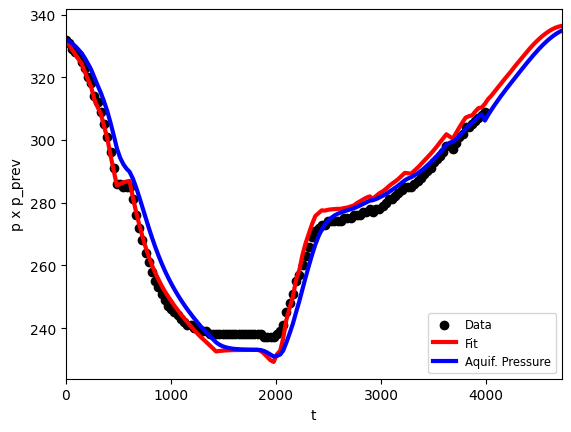

In [1190]:
## Gráfico de pressões

plt.scatter(t, p, label="Data", color="black")
plt.plot(t_fc, p_prev_fc, label=f"Fit", color="red", linewidth=3)
plt.plot(t_fc, pa_med_fc, label="Aquif. Pressure", color="blue", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("p x p_prev")
plt.xlim(0, fc.iloc[-1, 6])
plt.show()

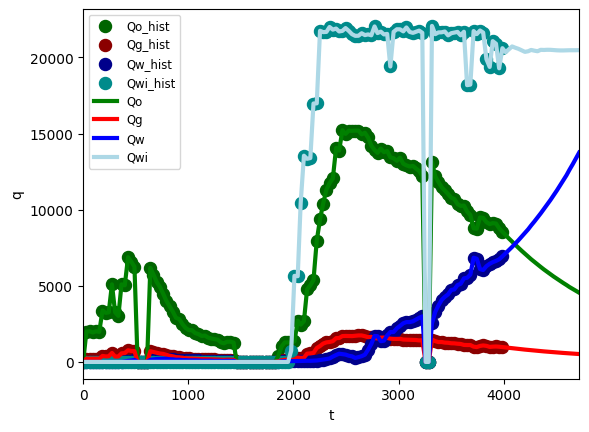

In [1191]:
## Gráfico de vazões

plt.scatter(t, qo, label="Qo_hist", color="darkgreen", s=75)
plt.scatter(t, qg/1000, label="Qg_hist", color="darkred", s=75)
plt.scatter(t, qw, label="Qw_hist", color="darkblue", s=75)
plt.scatter(t, qwi, label="Qwi_hist", color="darkcyan", s=75)
plt.plot(t_fc, qo_fc, label=f"Qo", color="green", linewidth=3)
plt.plot(t_fc, qg_fc/1000, label=f"Qg", color="red", linewidth=3)
plt.plot(t_fc, qw_fc, label=f"Qw", color="blue", linewidth=3)
plt.plot(t_fc, qwi_fc, label=f"Qwi", color="lightblue", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("q")
plt.xlim(0, fc.iloc[-1, 6])
plt.show()

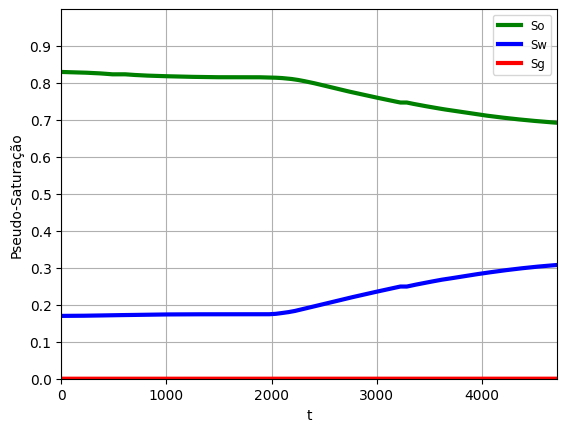

In [1192]:
## Gráfico de saturações

fig = plt.figure()
ax = fig.gca()
ax.set_yticks(np.arange(0, 1., 0.1))
plt.grid()
plt.plot(t_fc, so_fc, label="So", color="green", linewidth=3)
plt.plot(t_fc, sw_fc, label="Sw", color="blue", linewidth=3)
plt.plot(t_fc, sg_fc, label="Sg", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("Pseudo-Saturação")
plt.ylim(0.0, 1.0)
plt.xlim(0, fc.iloc[-1, 6])
plt.show()